# Image Recognition: Cats vs. Dogs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from pathlib import Path

Using TensorFlow backend.


### Preprocessing Images

In [2]:
def img_data_generator():
    return keras.preprocessing.image.ImageDataGenerator()

def img_data_generator2():
    return keras.preprocessing.image.ImageDataGenerator(
                rotation_range=30, 
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True
        )

In [3]:
train_data=img_data_generator2().flow_from_directory(Path.cwd() / '4_data' / 'train', seed=1)

Found 2000 images belonging to 2 classes.


In [4]:
test_data=img_data_generator2().flow_from_directory(Path.cwd() / '4_data' / 'validate', seed=1)

Found 800 images belonging to 2 classes.


In [5]:
train_data.next()[0].shape

(32, 256, 256, 3)

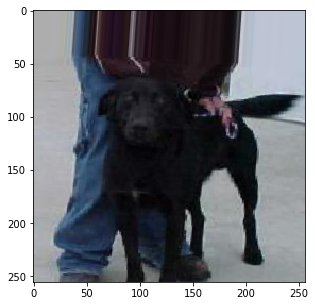

In [6]:
# train_data and test_data are iterators, show first image in training data
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(train_data.next()[0][0]/255., interpolation='nearest')

### Try first with simple CNN

In [8]:
# Define model steps
model=keras.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=train_data.next()[0].shape[1:]))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(250, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

In [9]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [10]:
# Fit the model
hist=model.fit_generator(train_data, 
                         epochs=2, 
                         steps_per_epoch=1000/32, 
                         verbose=1, 
                         validation_data=test_data, 
                         validation_steps=400/32,
                         class_weight='auto')

Epoch 1/2
32/31 [==============================] - 84s 3s/step - loss: 0.8161 - accuracy: 0.5050 - val_loss: 0.6899 - val_accuracy: 0.5048
Epoch 2/2
32/31 [==============================] - 87s 3s/step - loss: 0.7036 - accuracy: 0.4951 - val_loss: 0.6766 - val_accuracy: 0.5505


**-> Not really better than guessing**

### Use and extend complex inception model

In [12]:
# Start with base model without final ouput layer (include_top=False)
base_model=keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False) 

In [13]:
#Add custom layers
x=keras.layers.GlobalAveragePooling2D()(base_model.output)
x=keras.layers.Dense(250, activation='relu')(x)
predictions=keras.layers.Dense(2, activation='softmax')(x)

In [14]:
#Define model
model = keras.models.Model(inputs=base_model.input, outputs=predictions, name='Model_Inception')

In [15]:
# Inspect complete inception model
model.summary()

Model: "Model_Inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________

In [16]:
# Number of layers
len(model.layers)

314

In [17]:
# Only train last parameters
layers_to_freeze=310
for layer in model.layers[:layers_to_freeze]:
    layer.trainable=False
for layer in model.layers[layers_to_freeze:]:
    layer.trainable=True

In [18]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [19]:
# Fit the model
hist=model.fit_generator(train_data, 
                         epochs=2, 
                         steps_per_epoch=1000/32, 
                         verbose=1, 
                         validation_data=test_data, 
                         validation_steps=400/32,
                         class_weight='auto')

Epoch 1/2
32/31 [==============================] - 221s 7s/step - loss: 0.6033 - accuracy: 0.7354 - val_loss: 14.9640 - val_accuracy: 0.4928
Epoch 2/2
32/31 [==============================] - 184s 6s/step - loss: 0.3244 - accuracy: 0.8720 - val_loss: 16.1283 - val_accuracy: 0.5264
